## Modelling RV data of 51 Peg b
### As part of the exoplanet course "[De exoplanetas y otros demonios](https://www.dropbox.com/s/den1m7u7029a9bi/exoplanetas_2019.odp?dl=0)", at Bucaramanga, Santander, Colombia
##### Oscar Barragán, Dec 2019

In [5]:
#Import main libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Let us write a function to compute RV for a circular orbit
#input parameters are time t (vector with N elements)
and the model parameters
#in this case
#params[0] -> vz -> Systemic velocity of the star
#params[1] -> K  -> Doppler semi-amplitude
#params[2] -> P  -> Orbital period
#params[3] -> T0 -> time of minimum conjunction 
#This function returns a vector (N elements) of RVs at the times t
def calcula_RV(t,params):
    vz = params[0]
    K  = params[1]
    P  = params[2]
    t0 = params[3]
    vr = vz - K * np.sin(2*np.pi*(t-t0)/P)
    return vr

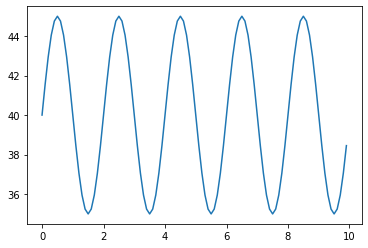

In [15]:
#Let us check if the function works by plotting an RV curve

#let us create a time vector between 0 and 10 days with a point each 0.1 days
t = np.arange(0,10,0.1)
#Let us give some values for the 4 parameters that define the RV of a circular orbit
vz = 40 #km/s
K = 5   #km/s
P = 2   #days
t0 = 13 #days

#Let us call the function to estimate the RV for a circular orbit
vr = calcula_RV(t,[vz,K,P,t0])
#Now we have a vector vr that contains the RV of our fictional star at the times t
plt.plot(t,vr)

#NOTE: If you want to know how the curve changes with different values
#I encourage you to modify the parameters and see how the plot changes
#this will give you a better idea of how the equation works ;-)

## Time to work with real data!
### We will work with the RV data of 51 Peg b, the first exoplanet discovered around a Sun-like star.
### You can find the original paper [here](https://www.nature.com/articles/378355a0)

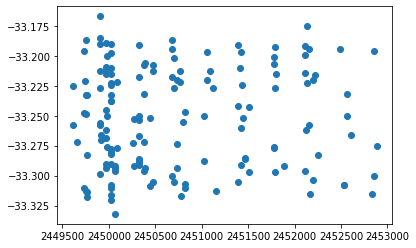

In [9]:
#if you are using Google collab, uncomment the next two lines
#from google.colab import files
#uploaded=files.upload()

#Let us load the file
td, rvd, ed = np.loadtxt('51peg.dat',unpack=True,usecols=[0,1,2])

#Let us plot the data
plt.plot(td,rvd,'o')
plt.show()

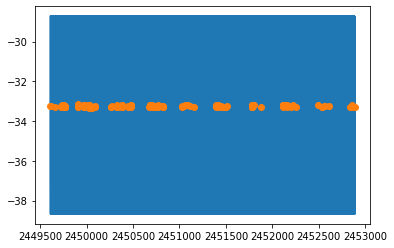

In [10]:
#Let us create a model using the time window from the observations
t = np.arange(min(td),max(td),0.1)

vz = -33.7
K = 5
P = 2
t0 = 13

vr = calcula_RV(t,[vz,K,P,t0])

#this line plots the model
plt.plot(t,vr)
#this line plots the data
plt.plot(td,rvd,'o')
plt.show()

In [12]:
#let us cumpute a chi2  function
def chi2(param,t,y,e):
    #let us compute the model to each obserations
    vr = calcula_RV(t,param)
    chi2 = 0
    for i in range(0,len(t)):
        chi2 += 1./2. * ( (vr[i] - y[i]) / e[i])**2
    return chi2

#let us test our chi2 function
chi = chi2([vz,K,P,t0],td,rvd,ed)
print(chi)

30281033.417483557


In [13]:
#Let us minimise the chi2 function

#first import fmin from scipy
from scipy.optimize import fmin

vz = -33.250
K = 0.06
P = 4.2
t0 = min(td)

#Let us tell to python the fuction that we want to minimise
params_final = fmin(chi2,[vz,K,P,t0],args=(td,rvd,ed))

print(params_final)

Optimization terminated successfully.
         Current function value: 238.019395
         Iterations: 182
         Function evaluations: 387
[-3.32561081e+01  6.03152653e-02  4.23078293e+00  2.52738292e+06]


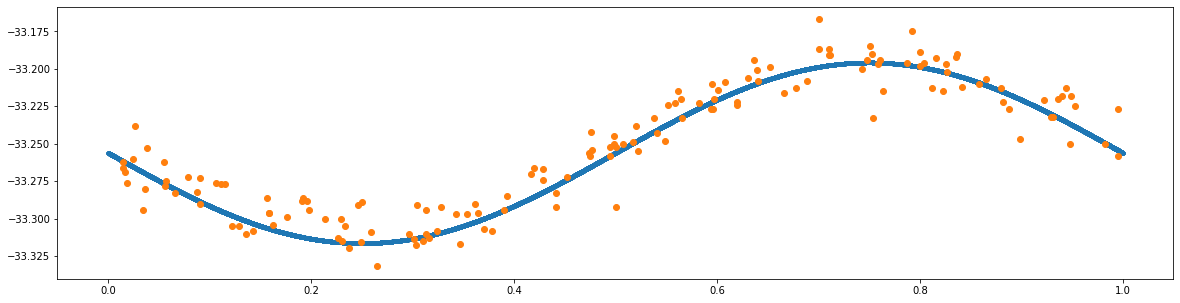

In [14]:
#Let us create a model using the time window from the observations
t = np.arange(min(td),max(td),0.1)

vr = calcula_RV(t,params_final)

#let us transform the times into phase
vz = params_final[0]
K = params_final[1]
P = params_final[2]
t0 = params_final[3]

phase_model = (t-t0)%P/P
phase_data  = (td-t0)%P/P

plt.figure(figsize=(20,5))
#this line plots the model
plt.plot(phase_model,vr,'.')
#this line plots the data
plt.plot(phase_data,rvd,'o')
plt.show()